# Modeling the Gravitational Slingshot Effect
### Sam Cochran, Jacob Murri Caleb Wilson

In [1]:
# Import packages
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style, rcParams
import matplotlib.animation as animation
#might want 3D stuff later
#from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

#Import in-house code
from simulation import gravity_acceleration, quiver_acceleration, simulate_mechanics
from plotting import plot_solution, get_acc_quivers, animate_solution

style.use('seaborn')
rcParams['figure.figsize'] = 10, 10

In our project we are attempting to model the physics of the slingshot effect, whereby a satellite can swing around a planet and receive a boost in speed so that it can successfully reach its destination. To begin to model this, we have to consider Newton's laws applied to the three bodies in question: the sun, the planet, and the satellite. Let $\mathbf{x}_1(t), \mathbf{x}_2(t), \mathbf{x}_3(t) \in \mathbb{R}^3$ be the positions of these three bodies, which have masses $m_1, m_2, m_3 \geq 0$. Then if $G$ is the universal gravitational constant, the equations of motion given by Newton's Second Law are
$$ 
\mathbf{x}_1''(t) = \frac{G m_2 (\mathbf{x}_2(t) - \mathbf{x}_1(t))}{\|\mathbf{x}_2(t) - \mathbf{x}_1(t)\|^3}
+ \frac{G m_3 (\mathbf{x}_3(t) - \mathbf{x}_1(t))}{\|\mathbf{x}_3(t) - \mathbf{x}_1(t)\|^3}
$$
$$ 
\mathbf{x}_2''(t) = \frac{G m_1 (\mathbf{x}_1(t) - \mathbf{x}_2(t))}{\|\mathbf{x}_1(t) - \mathbf{x}_2(t)\|^3}
+ \frac{G m_3 (\mathbf{x}_3(t) - \mathbf{x}_2(t))}{\|\mathbf{x}_3(t) - \mathbf{x}_2(t)\|^3}
$$
$$ 
\mathbf{x}_3''(t) = \frac{G m_2 (\mathbf{x}_2(t) - \mathbf{x}_3(t))}{\|\mathbf{x}_2(t) - \mathbf{x}_3(t)\|^3}
+ \frac{G m_1 (\mathbf{x}_1(t) - \mathbf{x}_3(t))}{\|\mathbf{x}_1(t) - \mathbf{x}_3(t)\|^3}
$$

In the situation that we are considering, the mass $m_3$ of the satellite is much smaller than the other masses. To account for this and simplify the model accordingly, we take the limit $m_3 \to 0$. In this limit the first two equations become their own system:
$$ 
\mathbf{x}_1''(t) = \frac{G m_2 (\mathbf{x}_2(t) - \mathbf{x}_1(t))}{\|\mathbf{x}_2(t) - \mathbf{x}_1(t)\|^3}
; \qquad  
\mathbf{x}_2''(t) = \frac{G m_1 (\mathbf{x}_1(t) - \mathbf{x}_2(t))}{\|\mathbf{x}_1(t) - \mathbf{x}_2(t)\|^3}
$$


and the third mass evolves in time depending on the solution for the first two masses:

$$ 
\mathbf{x}_3''(t) = \frac{G m_2 (\mathbf{x}_2(t) - \mathbf{x}_3(t))}{\|\mathbf{x}_2(t) - \mathbf{x}_3(t)\|^3}
+ \frac{G m_1 (\mathbf{x}_1(t) - \mathbf{x}_3(t))}{\|\mathbf{x}_1(t) - \mathbf{x}_3(t)\|^3}
$$

Now we can introduce dimensionless time, space, and mass parameters to make our system more tractable. Let $L$, $\Theta$, and $M$ be characteristic length, time, and mass scales, with units of meters, seconds, and kilograms, respectively. Then introduce the dimensionless parameters $\mathbf{u}_i = \mathbf{x}_i/L$, $\tau = t/\Theta$, and $\mu_i = m_i/M$. Then we can rewrite the equations as 

$$ 
\frac{L}{\Theta^2}\mathbf{u}_1''(\tau) = \frac{G  M \mu_2 L (\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau))}{L^3\|\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau)\|^3}
; \qquad  
\frac{L}{\Theta^2} \mathbf{u}_2''(\tau) = \frac{G M \mu_1 L (\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau))}{L^3\|\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau)\|^3}
; \qquad
\frac{L}{\Theta^2}\mathbf{u}_3''(\tau) = \frac{G M \mu_2 L (\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau))}{L^3\|\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau)\|^3}
+ \frac{G M \mu_1 L (\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau))}{L^3\|\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau)\|^3}
$$

which we can simplify to

$$ 
\mathbf{u}_1''(\tau) = \frac{GM \Theta^2}{L^3} \frac{ \mu_2 (\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau))}{\|\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau)\|^3}
; \qquad  
\mathbf{u}_2''(\tau) = \frac{GM \Theta^2}{L^3} \frac{\mu_1 (\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau))}{\|\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau)\|^3}
; \qquad
\mathbf{u}_3''(\tau) = \frac{GM \Theta^2}{L^3} \left[ \frac{ \mu_2 (\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau))}{\|\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau)\|^3}
+ \frac{\mu_1(\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau))}{\|\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau)\|^3}\right].
$$

Then by choosing our mass, length, and time scales accordingly, we can set $GM\Theta^2/L^3 = 1$, so that our equations have the dimensionless form

$$ 
\mathbf{u}_1''(\tau) = \frac{ \mu_2 (\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau))}{\|\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau)\|^3}
; \qquad  
\mathbf{u}_2''(\tau) = \frac{\mu_1 (\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau))}{\|\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau)\|^3}
; \qquad
\mathbf{u}_3''(\tau) = \frac{ \mu_2 (\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau))}{\|\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau)\|^3}
+ \frac{\mu_1(\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau))}{\|\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau)\|^3}.
$$

To make the equations easier to integrate numerically, we can make our system first order by setting $\mathbf{v}_i(\tau) = \mathbf{u}_i'(\tau)$. Then we have the equations

$$ 
\mathbf{u}_1'(\tau) = \mathbf{v}_1(\tau)
; \qquad 
\mathbf{u}_2'(\tau) = \mathbf{v}_2(\tau)
; \qquad 
\mathbf{u}_3'(\tau) = \mathbf{v}_3(\tau)
;
$$

$$
\mathbf{v}_1'(\tau) = \frac{ \mu_2 (\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau))}{\|\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau)\|^3}
; \qquad  
\mathbf{v}_2'(\tau) = \frac{\mu_1 (\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau))}{\|\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau)\|^3}
; \qquad
\mathbf{v}_3'(\tau) = \frac{ \mu_2 (\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau))}{\|\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau)\|^3}
+ \frac{\mu_1(\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau))}{\|\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau)\|^3}.
$$

Now we can write a function that computes these derivatives:

We can test our function using some example initial conditions:

In [3]:
# Set an orbit distance and initial velocity to create a circular orbit for the first two masses
r = 1
v = 1/(2*np.sqrt(r))
x1, v1 = np.array([+r, 0, 0]), np.array([0, +v, 0])
x2, v2 = np.array([-r, 0, 0]), np.array([0, v, 0])

# Select initial conditions for the third mass
x3, v3 = np.array([2, 0, 0]), np.array([0, 1, 0])

# Helper function
def create_ic_array(x1, x2, x3, v1, v2, v3): return np.concatenate((x1, x2, x3, v1, v2, v3))

# Get our initial conditions
ic1 = create_ic_array(x1, x2, x3, v1, v2, v3)

Let's test the function on some given initial conditions:

In [4]:
sol = simulate_mechanics(ic1, (0, 5), np.linspace(0, 5, 250))

We can see that the first and second masses stay close to a circle of radius 1:

In [5]:
x1, y1 = sol[0, :], sol[1, :]
x2, y2 = sol[3, :], sol[4, :]

print(x1**2+y1**2)
print(x2**2+y2**2)

[1.         1.         1.00000001 1.00000007 1.00000022 1.00000053
 1.0000011  1.00000204 1.00000347 1.0000054  1.00000789 1.00001126
 1.00001583 1.00002191 1.00002983 1.00003991 1.0000525  1.00006795
 1.00008662 1.00010886 1.00013508 1.00016566 1.00020101 1.00024157
 1.00028779 1.00034012 1.00039907 1.00046515 1.00053889 1.00062088
 1.00071171 1.00081203 1.00092249 1.00104381 1.00117675 1.0013221
 1.0014807  1.00165344 1.00184128 1.00204522 1.00226632 1.00250571
 1.00276458 1.00304421 1.00334594 1.00367105 1.00402001 1.00439401
 1.00479447 1.0052228  1.00568043 1.00616881 1.00668942 1.00724378
 1.00783346 1.0084601  1.00912541 1.00983118 1.01057929 1.01137174
 1.01221065 1.01309827 1.01403676 1.01502836 1.01607546 1.01718053
 1.01834619 1.01957514 1.02087023 1.0222344  1.02367074 1.02518248
 1.02677301 1.02844586 1.03020477 1.03205362 1.03399653 1.0360378
 1.03818199 1.04043388 1.04279849 1.04528124 1.04788787 1.05062437
 1.05349705 1.05651272 1.05967753 1.06299859 1.06648704 1.070153

Now we create some figures to model the dynamics of our system (restricted to the planar problem, for now).  We will use a toy problem to do this initial visualization, i.e. assume both primary masses are of mass 1.

Important: the plotting scheme below assumes the z coordinates of the initial condition are zero (these are indices 2, 5, 8, 11, 14, 17).

In each of these cases, there is something wrong with the outcome.  The plots below, more than anything, illustrate the difficulty of choosing initial conditions that allow for a successful slingshot maneuver.  Our task moving forward is to find a way to choose good initial conditions that allow for successful slingshot maneuvers.

I've gone ahead and hidden the inputs for all but the first plot, as they are essentially identical.

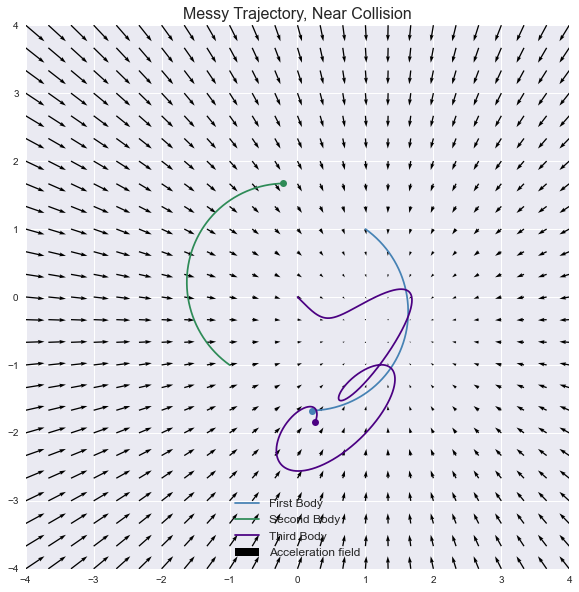

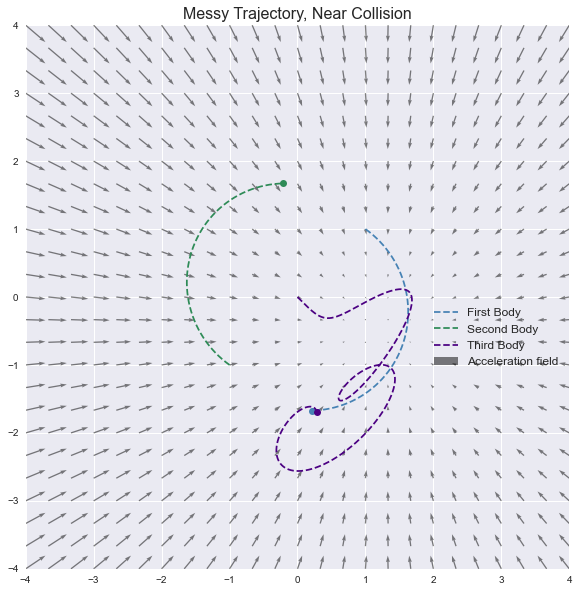

In [2]:
# Set up initial conditions and parameters
t0 = 0
tf = 10
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 0, 0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 .3, -.3, 0]) # Velocity 3 

# Solve the system
sol = solve_ivp(gravity_acceleration, (t0, tf), init, t_eval= np.linspace(t0, tf, 10000)).y

plot_solution(sol, 'Messy Trajectory, Near Collision')
animate_solution(sol, 'Messy Trajectory, Near Collision', 'messy', skip=40)


<video src="../Animations/messy.mp4" controls></video>

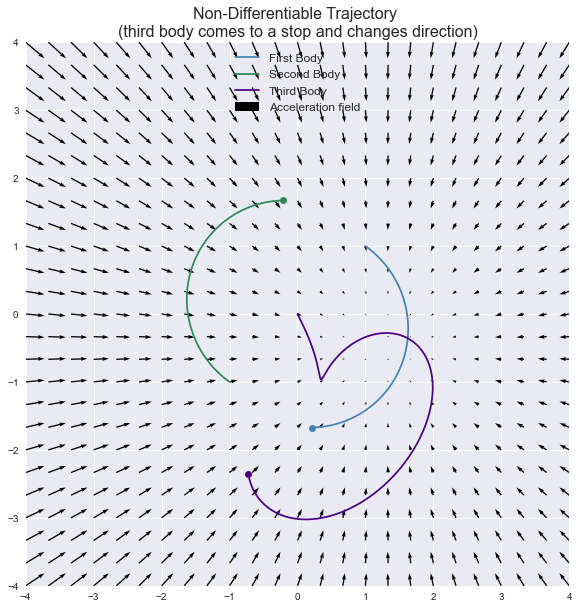

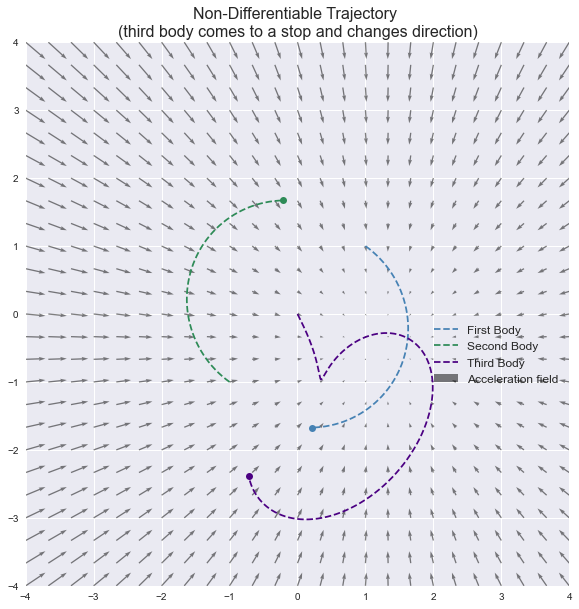

In [3]:
# Set up initial conditions and parameters
t0 = 0
tf = 10
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 0, 0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 .3, -.6, 0]) # Velocity 3 

# Solve the system
sol = solve_ivp(gravity_acceleration, (t0, tf), init, t_eval= np.linspace(t0, tf, 10000)).y

#BTW I don't think its non-differentiable I think it just looks like that from this scale, but I could be wrong
title = 'Non-Differentiable Trajectory \n(third body comes to a stop and changes direction)'
plot_solution(sol, title)

animate_solution(sol, title, 'jagged', skip=40)

<video src="../Animations/jagged.mp4" controls></video>

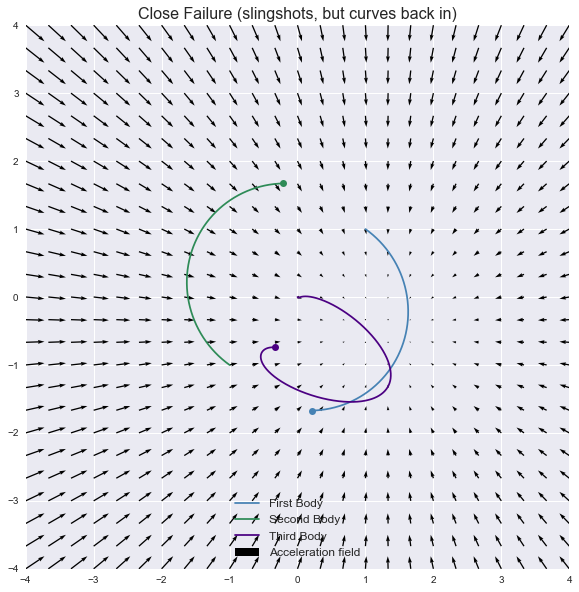

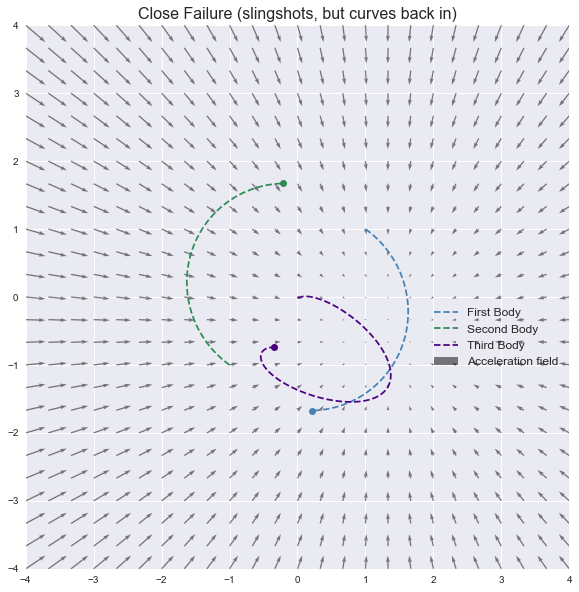

In [4]:
# Set up initial conditions and parameters
t0 = 0
tf = 10
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 0, 0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 .01, -.01, 0]) # Velocity 3 

# Solve the system
sol = solve_ivp(gravity_acceleration, (t0, tf), init, t_eval= np.linspace(t0, tf, 10000)).y

title = 'Close Failure (slingshots, but curves back in)'
plot_solution(sol, title)
animate_solution(sol, title, 'close', skip=40)

<video src="../Animations/close.mp4" controls></video>

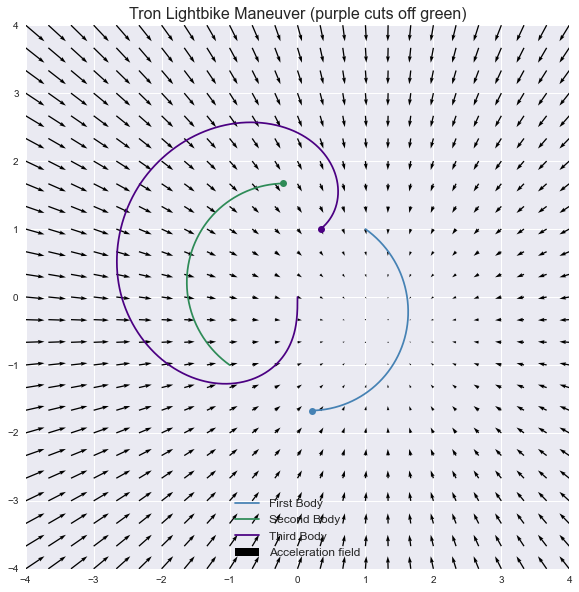

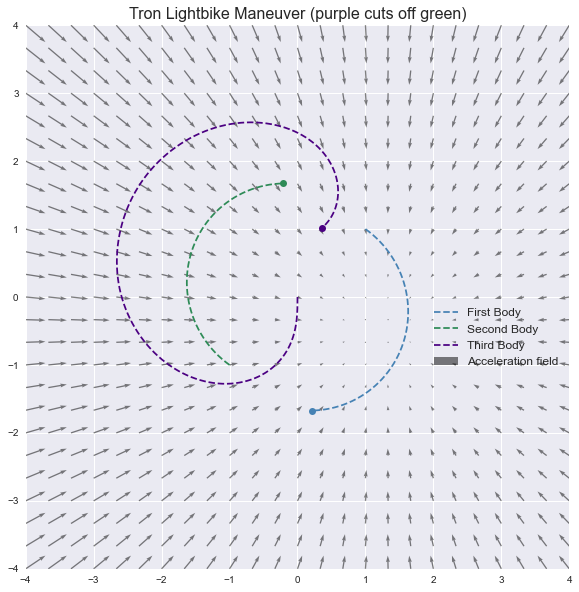

In [6]:
# Set up initial conditions and parameters
t0 = 0
tf = 10
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 0, 0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 0, -.7, 0]) # Velocity 3 

# Solve the system
sol = solve_ivp(gravity_acceleration, (t0, tf), init, t_eval= np.linspace(t0, tf, 10000)).y

title = 'Tron Lightbike Maneuver (purple cuts off green)'
plot_solution(sol, title)
animate_solution(sol, title, 'tron', skip=40)

<video src="../Animations/tron.mp4" controls></video>

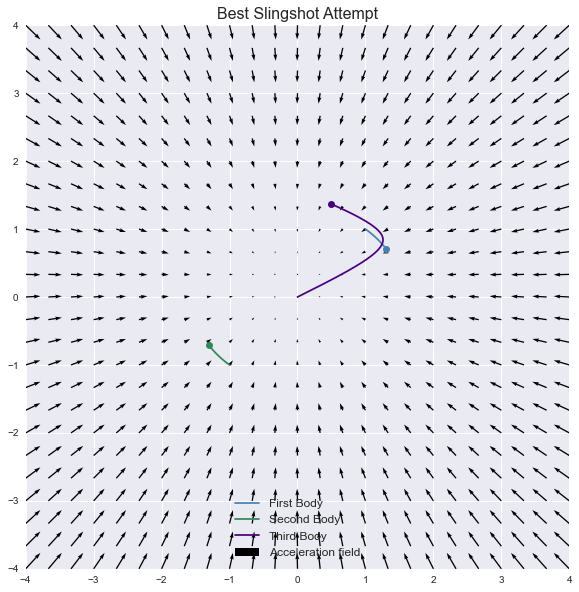

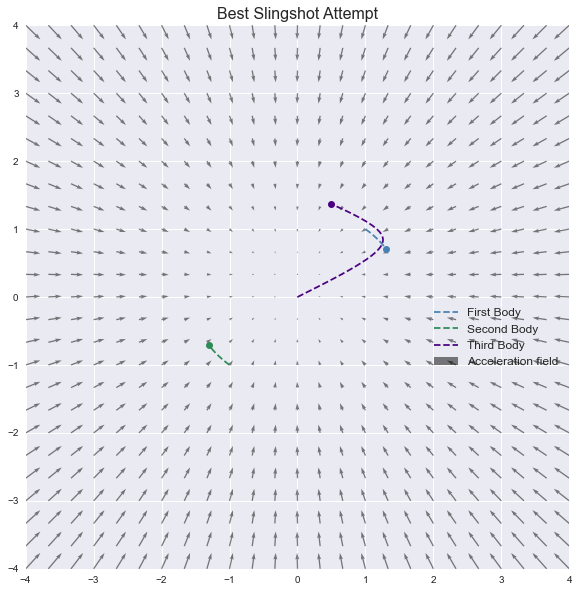

In [7]:
# Set up initial conditions and parameters
t0 = 0
tf = 1
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 0, 0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 2, 1, 0]) # Velocity 3 

# Solve the system
sol = solve_ivp(gravity_acceleration, (t0, tf), init, t_eval= np.linspace(t0, tf, 10000)).y

plot_solution(sol, 'Best Slingshot Attempt')
animate_solution(sol, 'Best Slingshot Attempt', 'best_attempt', skip=40)

<video src="../Animations/best_attempt.mp4" controls></video>

This is the closest we could get to a successful slingshot maneuver on this first attempt.  We came by this mostly by trial and error.  Though we have a long way to go, we note that the third body does indeed gain velocity and change direction by passing very close to the first body, so this is a solid initial model and illustrates our goal.

We further note that this is a very simple toy problem, with the first two primary bodies having mass of unity and the third body being considered as massless, so the masses, velocities, and positions for this model are pretty much meaningless, and only give us information relative to this model.